In [1]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import transformers

from sklearn.metrics import precision_score,recall_score,f1_score

import sys
sys.path.append("..")

/home/newdisk/jxh/anaconda/envs/sft2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
transformer_name = '../models/finbert'

tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)
## usage：
# tokenizer("hello world!")
# tokenizer.tokenize("hello world!")
# tokenizer.encode("hello world!")
# tokenizer.convert_ids_to_tokens(tokenizer.encode("hello world"))

In [10]:
dataset = datasets.load_dataset("../data/finan_news_senti_data", split=["train", "test"])
dataset[0][0]

Repo card metadata block was not found. Setting CardData to empty.


In [12]:
# 筛选
# dataset = [part_data.filter(lambda example: example["task"]=="FINFE" and ("积极" in example["output"] or "消极" in example["output"]) for part_data in dataset]

# input生成
def tokenize_and_numericalize_example(example, tokenizer):
    ids = tokenizer(example["正文"], truncation=True)["input_ids"]
    return {"ids": ids, "label": example['正负面']}
train_data = dataset[0].map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)
test_data = dataset[1].map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)

Map: 100%|██████████| 2400/2400 [00:01<00:00, 1896.55 examples/s]


In [13]:
pad_index = tokenizer.pad_token_id

In [14]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [15]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [16]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [17]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [20]:
batch_size = 16

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [21]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids):
        # ids = [batch size, seq len]
        output = self.transformer(ids, output_attentions=True)
        hidden = output.last_hidden_state
        # hidden = [batch size, seq len, hidden dim]
        attention = output.attentions[-1]
        # attention = [batch size, n heads, seq len, seq len]
        cls_hidden = hidden[:, 0, :]
        prediction = self.fc(torch.tanh(cls_hidden))
        # prediction = [batch size, output dim]
        return prediction

In [22]:
output_dim = 2
freeze = True
transformer = transformers.AutoModel.from_pretrained(transformer_name)
model = Transformer(transformer, output_dim, freeze)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 1,538 trainable parameters


In [24]:
lr = 1e-5
optimizer = optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()   # nn.CrossEntropyLoss()  nn.MSELoss()

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

In [26]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        attention_mask = (ids != pad_index).unsqueeze(-1).to(device)  # 生成attention_mask
        prediction = model(ids, attention_mask=attention_mask)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [27]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(torch.argmax(prediction, dim=1).cpu().numpy())
    
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    return np.mean(epoch_losses), np.mean(epoch_accs), f1

In [28]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [29]:
metrics = collections.defaultdict(list)

In [53]:
n_epochs = 10
best_valid_loss = float("inf")

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc, f1 = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    metrics["f1_score"].append(f1)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "../outputs/bert_sentiment.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")
    print(f"valid_f1: {f1:.3f}")

evaluating...: 100%|██████████| 215/215 [00:21<00:00,  9.98it/s]


epoch: 0
train_loss: 0.604, train_acc: 0.702
valid_loss: 0.579, valid_acc: 0.750
valid_f1: 0.750


evaluating...: 100%|██████████| 215/215 [00:21<00:00,  9.96it/s]


epoch: 1
train_loss: 0.602, train_acc: 0.701
valid_loss: 0.576, valid_acc: 0.750
valid_f1: 0.749


evaluating...: 100%|██████████| 215/215 [00:21<00:00,  9.96it/s]


epoch: 2
train_loss: 0.601, train_acc: 0.705
valid_loss: 0.573, valid_acc: 0.747
valid_f1: 0.746


evaluating...: 100%|██████████| 215/215 [00:21<00:00,  9.96it/s]


epoch: 3
train_loss: 0.597, train_acc: 0.710
valid_loss: 0.570, valid_acc: 0.753
valid_f1: 0.752


evaluating...: 100%|██████████| 215/215 [00:21<00:00,  9.96it/s]


epoch: 4
train_loss: 0.592, train_acc: 0.712
valid_loss: 0.568, valid_acc: 0.753
valid_f1: 0.753


evaluating...: 100%|██████████| 215/215 [00:21<00:00,  9.96it/s]


epoch: 5
train_loss: 0.590, train_acc: 0.713
valid_loss: 0.565, valid_acc: 0.753
valid_f1: 0.752


evaluating...: 100%|██████████| 215/215 [00:21<00:00,  9.96it/s]


epoch: 6
train_loss: 0.591, train_acc: 0.711
valid_loss: 0.563, valid_acc: 0.754
valid_f1: 0.752


evaluating...: 100%|██████████| 215/215 [00:21<00:00,  9.96it/s]


epoch: 7
train_loss: 0.590, train_acc: 0.712
valid_loss: 0.560, valid_acc: 0.754
valid_f1: 0.753


evaluating...: 100%|██████████| 215/215 [00:21<00:00,  9.96it/s]


epoch: 8
train_loss: 0.587, train_acc: 0.710
valid_loss: 0.558, valid_acc: 0.755
valid_f1: 0.754


evaluating...: 100%|██████████| 215/215 [00:21<00:00,  9.96it/s]


epoch: 9
train_loss: 0.584, train_acc: 0.718
valid_loss: 0.556, valid_acc: 0.759
valid_f1: 0.757


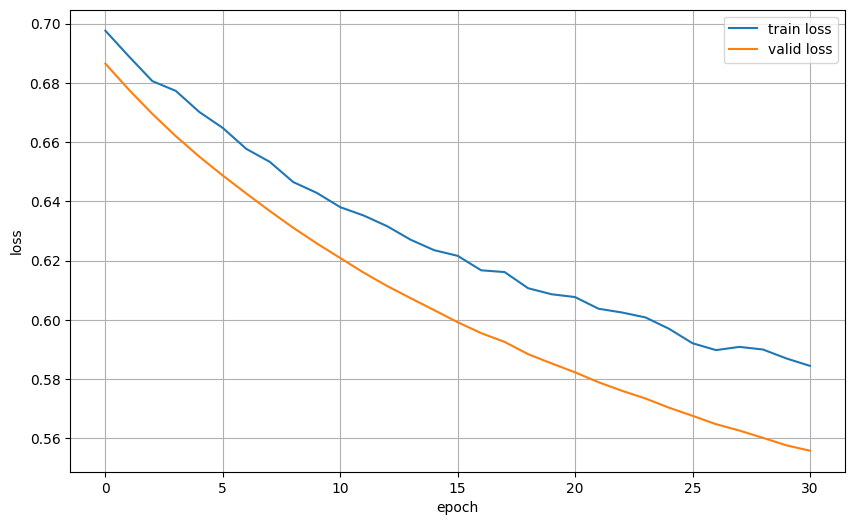

In [54]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
# ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

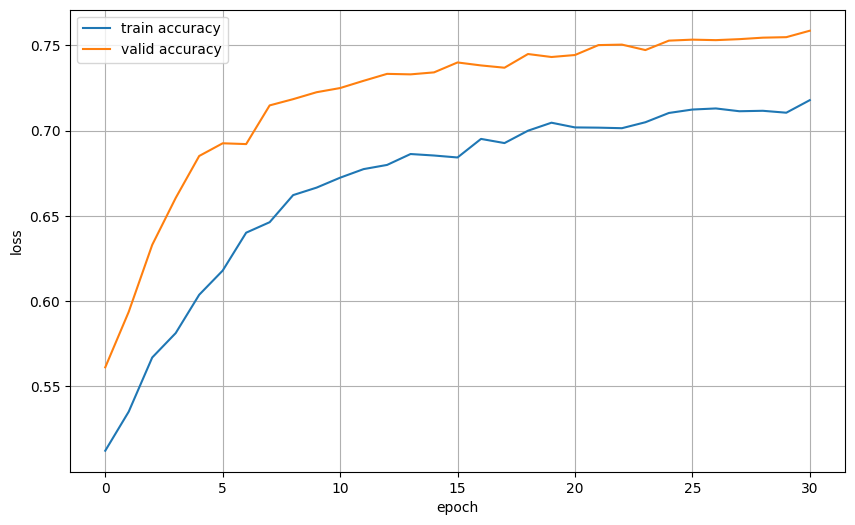

In [55]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
# ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [46]:
# model.load_state_dict(torch.load("transformer.pt"))

test_loss, test_acc, test_f1 = evaluate(test_data_loader, model, criterion, device)
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}, test_f1: {test_f1:.3f}")

evaluating...: 100%|██████████| 150/150 [00:14<00:00, 10.35it/s]

test_loss: 0.582, test_acc: 0.748, test_f1: 0.746


In [47]:
def predict_sentiment(text, model, tokenizer, device):
    ids = tokenizer(text)["input_ids"]
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [58]:
text = "迪威迅股权质押违约 控股股东或被动减持"
# text = "银行股全线飘绿 平安银行跌4%"

predict_sentiment(text, model, tokenizer, device)

(0, 0.6087827682495117)

In [59]:
text = "平安银行理财子公司获批筹建：注册资本50亿 股份行第五家"

predict_sentiment(text, model, tokenizer, device)

(1, 0.6610144376754761)